## Report to Special Topics : Computational Physics
### Part A.2 : Real Field Transvere Model by Sparse Matrix
* Author:Yen-Tung Lin
* ID: 109022802

### Reference : 
* Yan He and Hao Guo J. Stat. Mech. (2017) 093101

### Model
* <font size=4 face="黑體">$H$ = $-J\sum_{i}S^{x}_{i}S^{x}_{i+1}$ + $h^{z}S^{z}_{i}$
### To Calculate
* $\frac{E_{0}}{N}$ (Groung State Energy / N) 
* $E_{1}-E_{0}$ ( Gap )
* $\xi/N$ ( Correlation Length / N )
* $\frac{\partial^{2}{E_0}}{\partial{h^{2}_{z}}}$
* $<S_{x}>_{H=H_{0}+0.01*S_{x}}$ ( To see SSB )
* $<S_{x}>$
* $S_{A/B}$ vs $ln(N)$( Compare Bipartite Entropy Growth near vritical point  )
* $S_{A}$ vs $N_{A}$ ( Entropy of Subsystem $S_{A}$ )


### Classes Import

In [1]:
import os
import math
import pandas as pd
import random
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.optimize import curve_fit

### Ploting Import

In [2]:
## Basic parameter
cnames = {                        
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chocolate':            '#D2691E',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'orangered':            '#FF4500',
'orchid':               '#DA70D6'}
carr = []
for cmap in cnames.keys():                          ## color array
    carr.append(cmap)
marr = ['o-', 'x-', '^-', 's-', 'p-', '*-', 'h-']   ## marker array

### Pauli matrix ( normal and sparse )

In [3]:
hbar = 1

SigmaX = np.array([[0,1],[1,0]])
SigmaY = np.array([[0,-1j],[1j,0]])
SigmaZ = np.array([[1,0],[0,-1]])

sparseSigmaX = sparse.csr_matrix([[0,1],[1,0]]).astype(float)
sparseSigmaY = sparse.csr_matrix([[0,-1j],[1j,0]]).astype(float)
sparseSigmaZ = sparse.csr_matrix([[1,0],[0,-1]]).astype(float)

/home/aronton/anaconda3/lib/python3.8/site-packages/scipy/sparse/data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self._deduped_data().astype(dtype, casting=casting, copy=copy),


### Spin matrix ( normal and sparse )

In [4]:
hbar = 1

Sx = hbar/2*SigmaX
Sy = hbar/2*SigmaY
Sz = hbar/2*SigmaZ

sparseSx = hbar/2*sparseSigmaX
sparseSy = hbar/2*sparseSigmaY
sparseSz = hbar/2*sparseSigmaZ

I = np.array([[1,0],[0,1]])
sparseI = sparse.csr_matrix(I).astype(float)



### Hamiltonian Function
* <font size=4 face="黑體"> $H$ = $-J\sum_{i}S^{x}_{i}S^{x}_{i+1}$ + $h^{z}S^{z}_{i}$

In [5]:
def Hamiltonain(L,Sx,Sy,Sz,I,j,hx,hz):

    Sxtot = np.zeros((2**L, 2**L))
    Sytot = np.zeros((2**L, 2**L))
    Sztot = np.zeros((2**L, 2**L))
    Htot = np.zeros((2**L, 2**L))
    SxList = []
    SyList = []
    SzList = []

    for k in range(L):
        x = Sx
        y = Sy
        z = Sz
        if(k == 0):
            for i in range(L-1):
                x = np.kron(x,I)
                y = np.kron(y,I)
                z = np.kron(z,I)
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)
        elif(k == L-1):
            for i in range(L-1):
                x = np.kron(I,x)
                y = np.kron(I,y)
                z = np.kron(I,z)
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)
        else:
            for i in range(k):
                x = np.kron(I,x)
                y = np.kron(I,y)
                z = np.kron(I,z)
            for i in range(k, L-1):
                x = np.kron(x,I)
                y = np.kron(y,I)
                z = np.kron(z,I)
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)

    if(hx == 0):
        for i in range(L):
            if i < L-1:
                Htot = Htot - j*SxList[i] @ SxList[i+1] - hz*SzList[i] 
            else:
                Htot = Htot - j*SxList[i] @ SxList[0] - hz*SzList[i] 
    else:
        for i in range(L):
            if i < L-1:
                Htot = Htot - j*SxList[i] @ SxList[i+1] - hz*SzList[i] - 1j*hx*SxList[i]
            else:
                Htot = Htot - j*SxList[i] @ SxList[0] - hz*SzList[i] - 1j*hx*SxList[i]

    for i in range(L):
        Sxtot = Sxtot + SxList[i]
        Sytot = Sytot + SyList[i]
        Sztot = Sztot + SzList[i]
    
    return Htot, Sztot, SzList, Sxtot, SxList


def sparseHamiltonain(L,sparseSx,sparseSy,sparseSz,sparseI,j,hx,hz):

    Sxtot = sparse.csr_matrix((2**L, 2**L)).astype(float)
    Sytot = sparse.csr_matrix((2**L, 2**L)).astype(float)
    Sztot = sparse.csr_matrix((2**L, 2**L)).astype(float)
    Htot = sparse.csr_matrix((2**L, 2**L)).astype(float)
    SxList = []
    SyList = []
    SzList = []

    for k in range(L):
        x = sparseSx
        y = sparseSy
        z = sparseSz
        if(k == 0):
            for i in range(L-1):
                x = sparse.kron(x,sparseI,format = 'csr')
                y = sparse.kron(y,sparseI,format = 'csr')
                z = sparse.kron(z,sparseI,format = 'csr')
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)
        elif(k == L-1):
            for i in range(L-1):
                x = sparse.kron(sparseI,x,format = 'csr')
                y = sparse.kron(sparseI,y,format = 'csr')
                z = sparse.kron(sparseI,z,format = 'csr')
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)
        else:
            for i in range(k):
                x = sparse.kron(sparseI,x,format = 'csr')
                y = sparse.kron(sparseI,y,format = 'csr')
                z = sparse.kron(sparseI,z,format = 'csr')
            for i in range(k, L-1):
                x = sparse.kron(x,sparseI,format = 'csr')
                y = sparse.kron(y,sparseI,format = 'csr')
                z = sparse.kron(z,sparseI,format = 'csr')
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)

    if(hx == 0):
        for i in range(L):
            if i < L-1:
                Htot = Htot - j*SxList[i] @ SxList[i+1] - hz*SzList[i] 
            else:
                Htot = Htot - j*SxList[i] @ SxList[0] - hz*SzList[i] 
    else:
        for i in range(L):
            if i < L-1:
                Htot = Htot - j*SxList[i] @ SxList[i+1] - hz*SzList[i] - 1j*hx*SxList[i]
            else:
                Htot = Htot - j*SxList[i] @ SxList[0] - hz*SzList[i] - 1j*hx*SxList[i]


    for i in range(L):
        Sxtot = Sxtot + SxList[i]
        Sytot = Sytot + SyList[i]
        Sztot = Sztot + SzList[i]

    return Htot, Sztot, SzList, Sxtot, SxList
    
   

### Exact solution

In [6]:
def Lambda_a(L):
    L_a = np.arange(-(L-1),(L-1+1),2)*np.pi/L
    return L_a

def Lambda_p(N):
    L_p = np.arange(-(L-2),(L-2+1),2)*np.pi/L
    L_p = np.delete(L_p, np.where(L_p == 0))
    return L_p

def exact_E0(L,h):
    L_a = Lambda_a(L)
    E_k = np.sqrt( (1/2)**2 + h**2 + 1*h*np.cos(L_a))
    E_0 = -1/2*np.sum(E_k)
    return E_0

def exact_E1(L,h):
    L_p = Lambda_p(L)
    # E_k = np.sqrt( 2*h**2 + 2*(h**2)*2*np.cos(L_a))
    E_k = np.sqrt( (1/2)**2 + h**2 + 1*h*np.cos(L_p))
    E_1 = -1/2 -1/2*np.sum(E_k) 
    return E_1

# check ok
L = 6; h = 0.25
E0_exact = exact_E0(L,h)
E1_exact = exact_E1(L,h)
print('E0_exact/L = ', E0_exact)
print('E1_exact/L = ', E1_exact)

E0_exact/L =  -1.5961736409009188
E1_exact/L =  -1.594450529658367


## 實數 Hamiltonian 做 ED

### Real Hamiltonian using sparse matrix

### Load data

In [ ]:
E0 = np.load("./E0_L1=%d_L2=%d_hzpoint=%d_sparse.npy" %(Llist[0],Llist[-1],len(hz)))
E1 = np.load("./E1_L1=%d_L2=%d_hzpoint=%d_sparse.npy" %(Llist[0],Llist[-1],len(hz)))
gap = np.load("./gap_L1=%d_L2=%d_hzpoint=%d_sparse.npy" %(Llist[0],Llist[-1],len(hz)))
lamda = np.load("./lamda_L1=%d_L2=%d_hzpoint=%d_sparse.npy" %(Llist[0],Llist[-1],len(hz)))
SzE = np.load("./SzE_L1=%d_L2=%d_hzpoint=%d_sparse.npy" %(Llist[0],Llist[-1],len(hz)))
SxE = np.load("./SxE_L1=%d_L2=%d_hzpoint=%d_sparse.npy" %(Llist[0],Llist[-1],len(hz)))

entropy = []

for l in range(len(Llist)):
    entropy.append(np.load("./Entropy_N=%d_Na=%d_hzpoint=%d_sparse.npy" %(Llist[-1],Llist[l],len(hz))))

### Calculation 

In [7]:
Llist = np.linspace(4,18,(18-4)//2 + 1,dtype = int)
print(Llist)
hz = np.linspace(0,1,51)
E0 = np.zeros((len(Llist),len(hz)))
E1 = np.zeros((len(Llist),len(hz)))
# entropy = np.zeros((len(Llist),len(Llist)+1,len(hz)))

E0_exact = np.zeros((len(Llist),len(hz)))
E1_exact = np.zeros((len(Llist),len(hz)))

entropy = []
entropy_tensor = []

np.zeros((len(Llist),len(Llist) + 1))
gap = np.zeros((len(Llist),len(hz)))
gap_exact = np.zeros((len(Llist),len(hz)))

lamda = np.zeros((len(Llist),len(hz)))
lamda_exact = np.zeros((len(Llist),len(hz)))

SzE = np.zeros((len(Llist),len(hz)))
SxE = np.zeros((len(Llist),len(hz)))


lamda = np.zeros((len(Llist),len(hz)))
lamda_exact = np.zeros((len(Llist),len(hz)))

for l in range(len(Llist)):
    L = Llist[l]
    print("L:",L)
    entropy.append(np.zeros((L+1,len(hz))))
    entropy_tensor.append(np.zeros((L+1,len(hz))))
    for hz_i in range(len(hz)):

        SHtot, Sztot, Szlist, Sxtot, Sxlist = sparseHamiltonain(L,sparseSx,sparseSy,sparseSz,sparseI,1,0,hz[hz_i])
        ee, Sv = sparse.linalg.eigsh(SHtot,which="SA")
        ex, Svx = sparse.linalg.eigsh(SHtot + 0.01*Sxtot,which="SA")

        index = np.argsort(ee)
        ee = sorted(ee)

        E0[l,hz_i] = ee[0]
        E1[l,hz_i] = ee[1]
        gap[l,hz_i] = ee[1] - ee[0]
        lamda[l,hz_i] = 1/gap[l,hz_i]/L
        SzE[l,hz_i] = Sv[:,index[0]] @ Szlist[0] @ Sv[:,index[0]] 
        SxE[l,hz_i] = Svx[:,index[0]] @ Sxlist[0] @ Svx[:,index[0]] 

        E0_exact[l,hz_i] = exact_E0(L,hz[hz_i])
        E1_exact[l,hz_i] = exact_E1(L,hz[hz_i])
        gap_exact[l,hz_i] = E1_exact[l,hz_i] - E0_exact[l,hz_i]
        lamda_exact[l,hz_i] = 1/(E1_exact[l,hz_i] - E0_exact[l,hz_i])/L


        Na = np.linspace(0,L,L+1,dtype = int)
        for na in range(len(Na)):
            rv = np.reshape(Sv[:,0], (2**Na[na],2**(L-Na[na])))
            s = np.linalg.svd(rv, full_matrices=False, compute_uv=False)

            for svalue in s:
                entropy[l][na,hz_i] = entropy[l][na,hz_i] - (svalue)*(svalue)*np.log(svalue*svalue)

np.save("./E0_L1=%d_L2=%d_hzpoint=%d_sparse" %(Llist[0],Llist[-1],len(hz)),E0)
np.save("./E1_L1=%d_L2=%d_hzpoint=%d_sparse" %(Llist[0],Llist[-1],len(hz)),E1)
np.save("./gap_L1=%d_L2=%d_hzpoint=%d_sparse" %(Llist[0],Llist[-1],len(hz)),gap)
np.save("./lamda_L1=%d_L2=%d_hzpoint=%d_sparse" %(Llist[0],Llist[-1],len(hz)),lamda)
np.save("./SzE_L1=%d_L2=%d_hzpoint=%d_sparse" %(Llist[0],Llist[-1],len(hz)),SzE)
np.save("./SxE_L1=%d_L2=%d_hzpoint=%d_sparse" %(Llist[0],Llist[-1],len(hz)),SxE)

for l in range(len(Llist)):
    np.save("./Entropy_N=%d_Na=%d_hzpoint=%d_sparse" %(Llist[-1],Llist[l],len(hz)),entropy[l])


[ 4  6  8 10 12 14 16 18]
L: 4


<ipython-input-7-d9548afaaf5b>:52: RuntimeWarning: divide by zero encountered in double_scalars
  lamda_exact[l,hz_i] = 1/(E1_exact[l,hz_i] - E0_exact[l,hz_i])/L


L: 6
L: 8
L: 10
L: 12
L: 14
L: 16
L: 18


<ipython-input-7-d9548afaaf5b>:45: RuntimeWarning: divide by zero encountered in double_scalars
  lamda[l,hz_i] = 1/gap[l,hz_i]/L


IndexError: index 18 is out of bounds for axis 0 with size 5

## Data Plot

* <font size=5 face="黑體">$\frac{E_{0}}{N}$ (Groung State Energy / N) 

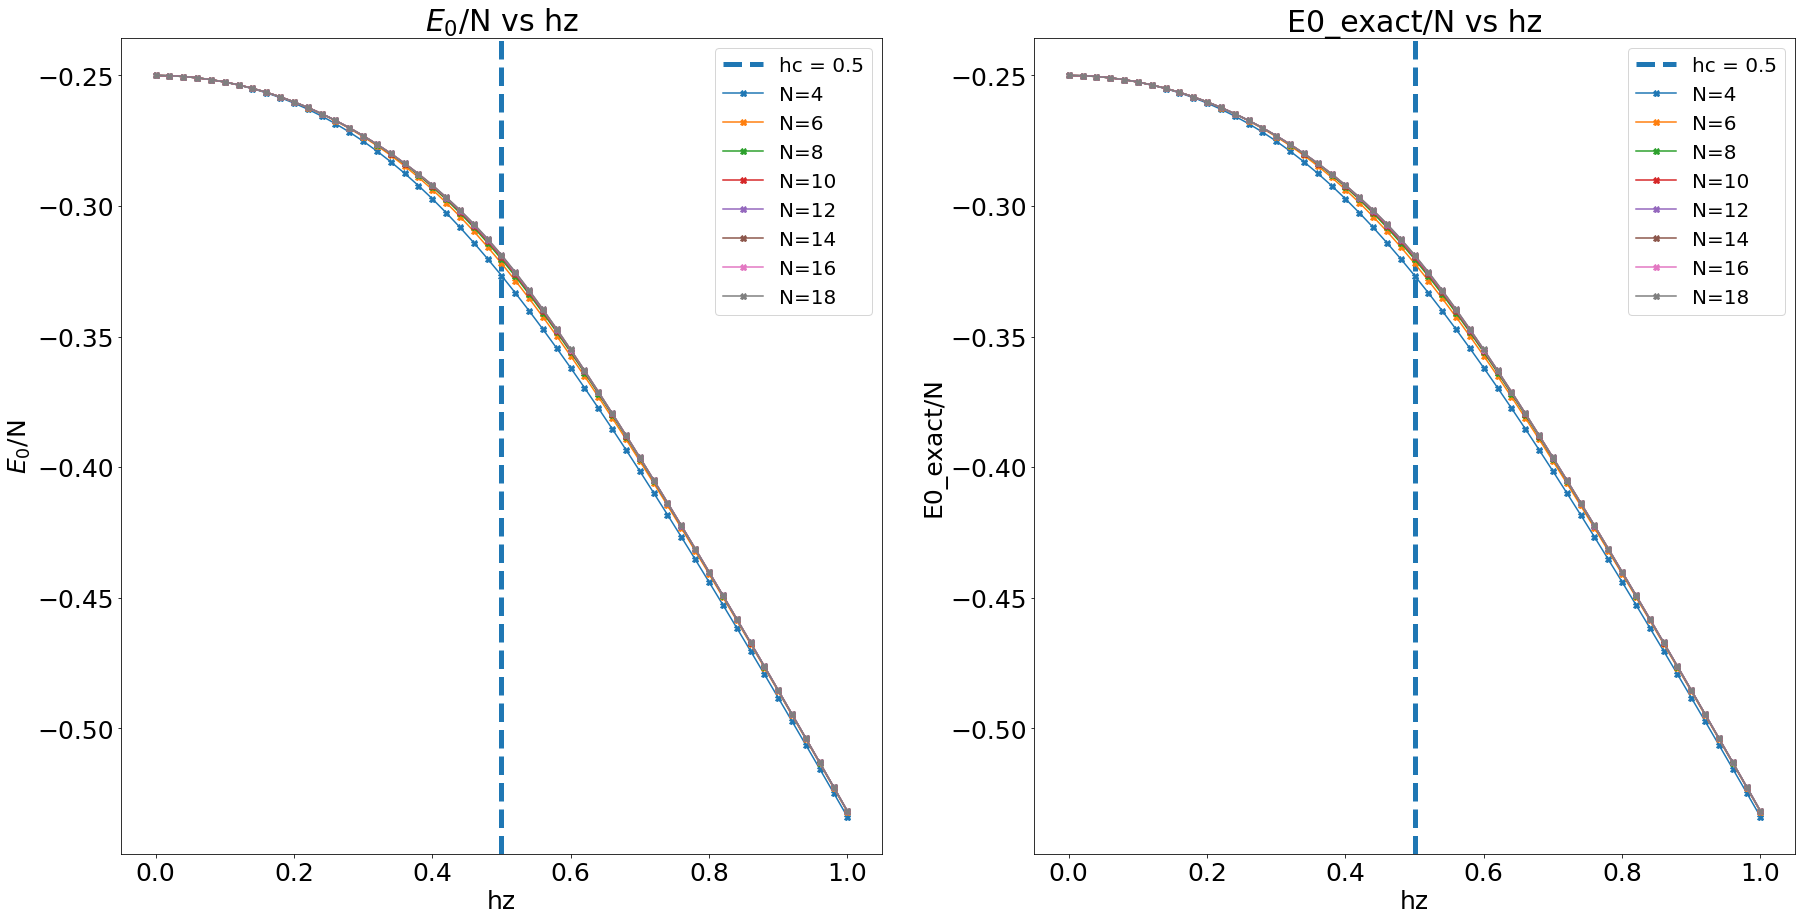

In [9]:
fig, ax = plt.subplots(1,2,figsize=(30,15))
for l in range(len(Llist)):
    L = Llist[l]
    if(l==0):
        ax[0].axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[0].plot(hz[:],E0[l,:]/L, "-X", label = "N=%d" %L)
    ax[0].set_title("$E_0$/N vs hz", fontsize = 30)
    ax[0].set_ylabel("$E_0$/N", fontsize = 25)
    ax[0].set_xlabel("hz", fontsize = 25)
    ax[0].tick_params(axis='x', labelsize=25)
    ax[0].tick_params(axis='y', labelsize=25)
    ax[0].legend(loc = "best", fontsize=20)


    if(l==0):
        ax[1].axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[1].plot(hz[:],E0_exact[l,:]/L, "-X", label = "N=%d" %L)
    ax[1].set_title("E0_exact/N vs hz", fontsize = 30)
    ax[1].set_ylabel("E0_exact/N", fontsize = 25)
    ax[1].set_xlabel("hz", fontsize = 25)
    ax[1].tick_params(axis='x', labelsize=25)
    ax[1].tick_params(axis='y', labelsize=25)
    ax[1].legend(loc = "best", fontsize=20)


* <font size=6 face="黑體">The system must be gapless below critical point 

* <font size=5 face="黑體">$E_{1}-E_{0}$ ( Gap )

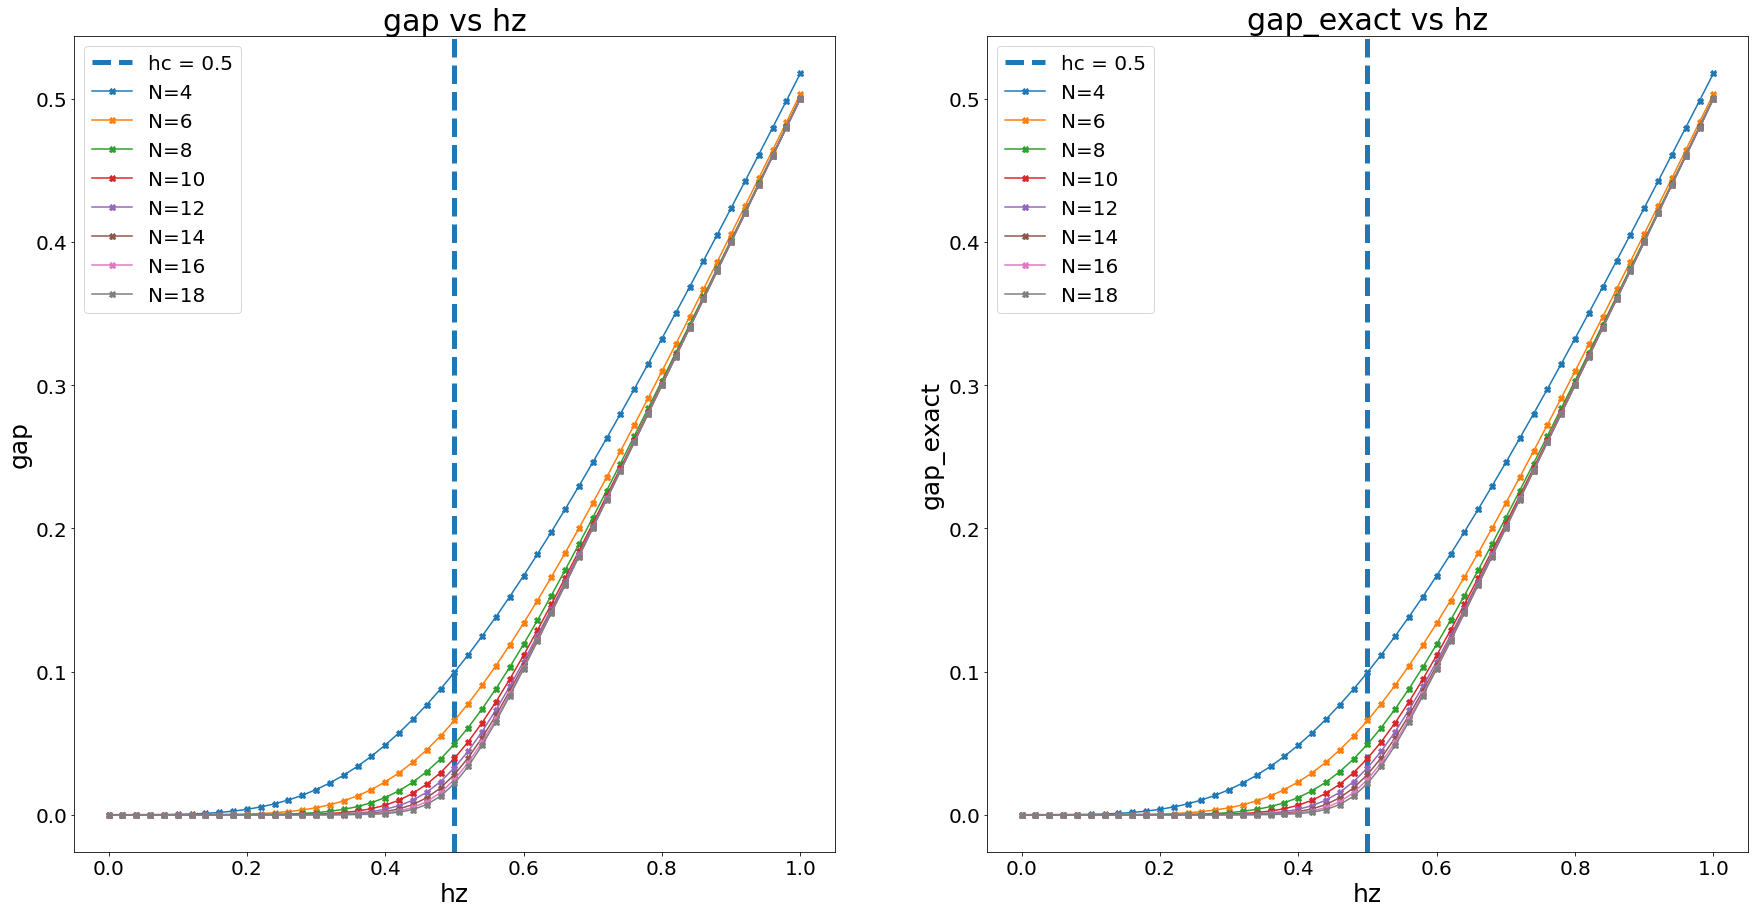

In [10]:
fig, ax = plt.subplots(1,2,figsize=(30,15))
for l in range(len(Llist)):
    L = Llist[l]
    if(l==0):
        ax[0].axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[0].plot(hz[:],gap[l,:], "-X", label = "N=%d" %L)
    ax[0].set_title("gap vs hz", fontsize = 30)
    ax[0].set_ylabel("gap", fontsize = 25)
    ax[0].set_xlabel("hz", fontsize = 25)
    ax[0].tick_params(axis='x', labelsize=20)
    ax[0].tick_params(axis='y', labelsize=20)
    ax[0].legend(loc = "upper left", fontsize=20)

    if(l==0):
        ax[1].axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[1].plot(hz[:],gap_exact[l,:], "-X", label = "N=%d" %L)
    ax[1].set_title("gap_exact vs hz", fontsize = 30)
    ax[1].set_ylabel("gap_exact", fontsize = 25)
    ax[1].set_xlabel("hz", fontsize = 25)
    ax[1].tick_params(axis='x', labelsize=20)
    ax[1].tick_params(axis='y', labelsize=20)
    ax[1].legend(loc = "best", fontsize=20)

* <font size=6 face="黑體"> Dmensionless quantity must intersec at critical point $h_c$ = 0.5

* <font size=5 face="黑體"> $\xi/N$ ( Correlation Length / N )

<ipython-input-11-00f20bc341c2>:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0].set_ylim(0,10**6)
<ipython-input-11-00f20bc341c2>:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1].set_ylim(0,10**6)
<ipython-input-11-00f20bc341c2>:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0].set_ylim(0,10**6)
<ipython-input-11-00f20bc341c2>:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1].set_ylim(0,10**6)
<ipython-input-11-00f20bc341c2>:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0].set_ylim(0,10**6)
<ipython-input-11-00f20bc341c2>:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1

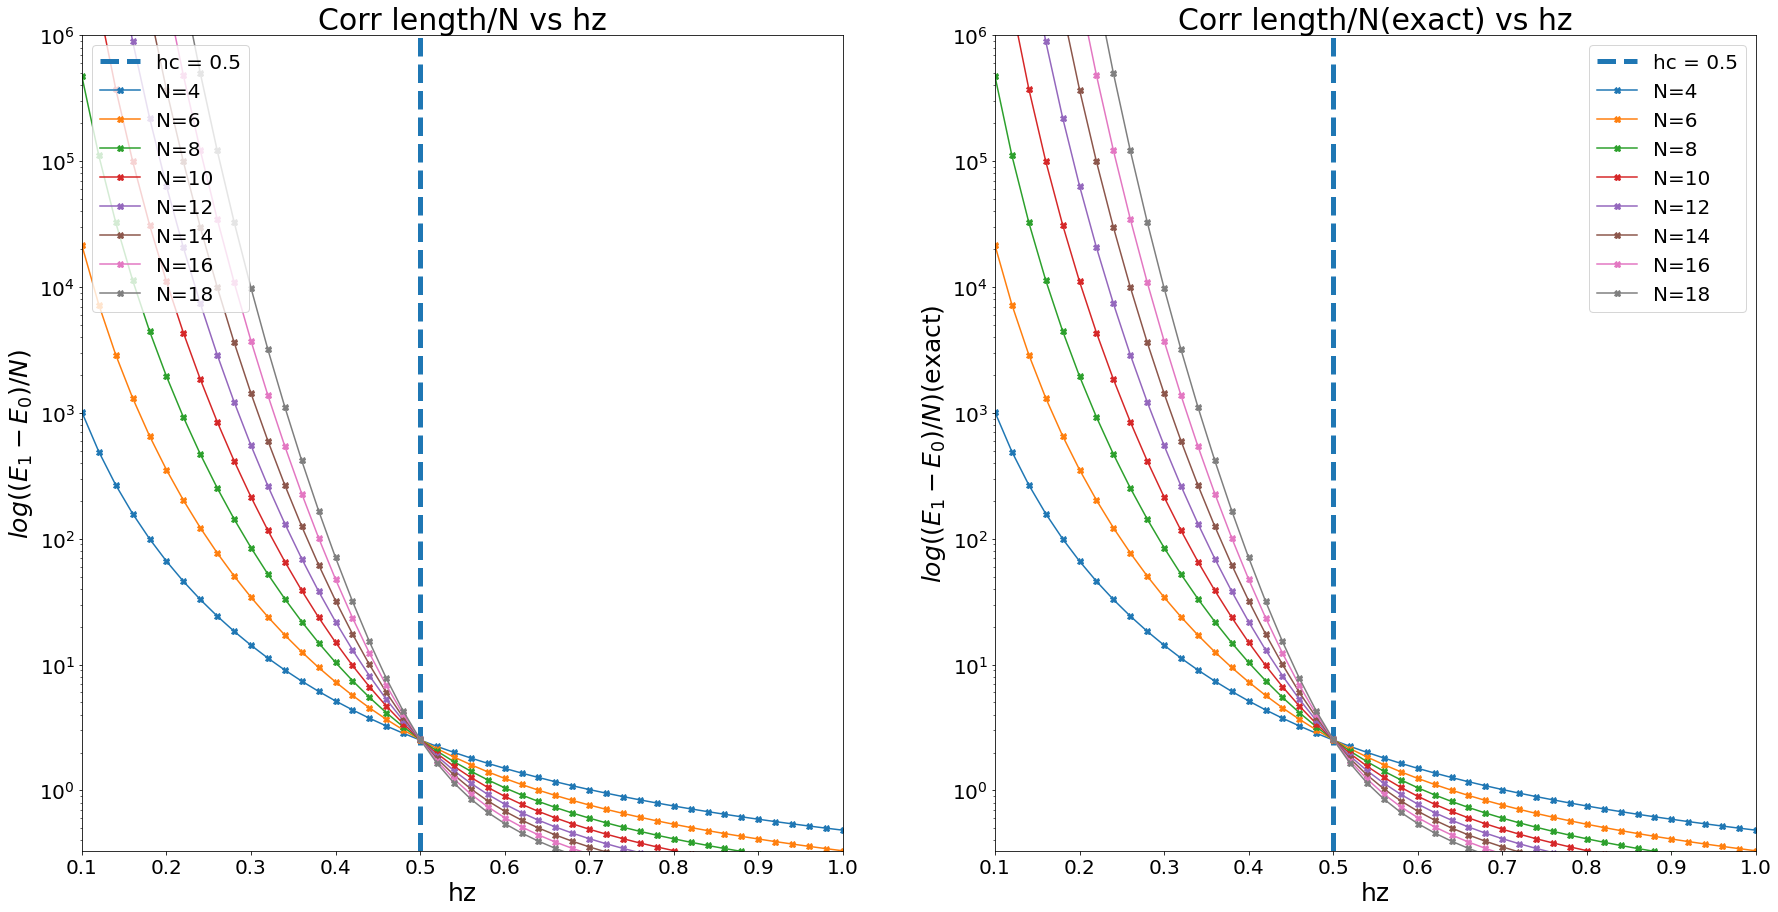

In [11]:
fig, ax = plt.subplots(1,2,figsize=(30,15))
for l in range(len(Llist)):
    L = Llist[l]
    if(l==0):
        ax[0].axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[0].plot(hz[:],lamda[l,:], "-X", label = "N=%d" %L)
    ax[0].set_title("Corr length/N vs hz", fontsize = 30)
    ax[0].set_ylabel("$log((E_1-E_0)/N)$", fontsize = 25)
    ax[0].set_xlabel("hz", fontsize = 25)
    ax[0].set_ylim(0,10**6)
    ax[0].set_xlim(0.1,1)
    ax[0].tick_params(axis='x', labelsize=20)
    ax[0].tick_params(axis='y', labelsize=20)
    ax[0].set_yscale('log')
    ax[0].legend(loc = "upper left", fontsize=20)

    if(l==0):
        ax[1].axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[1].plot(hz[:],lamda_exact[l,:], "-X", label = "N=%d" %L)
    ax[1].set_title("Corr length/N(exact) vs hz", fontsize = 30)
    ax[1].set_ylabel("$log((E_1-E_0)/N)$(exact)", fontsize = 25)
    ax[1].set_xlabel("hz", fontsize = 25)
    ax[1].set_ylim(0,10**6)
    ax[1].set_xlim(0.1,1)
    ax[1].set_yscale('log')
    ax[1].tick_params(axis='x', labelsize=20)
    ax[1].tick_params(axis='y', labelsize=20)
    ax[1].legend(loc = "best", fontsize=20)

* <font size=5 face="黑體">  $\frac{\partial^{2}{E_0}}{\partial{h^{2}_{z}}}$


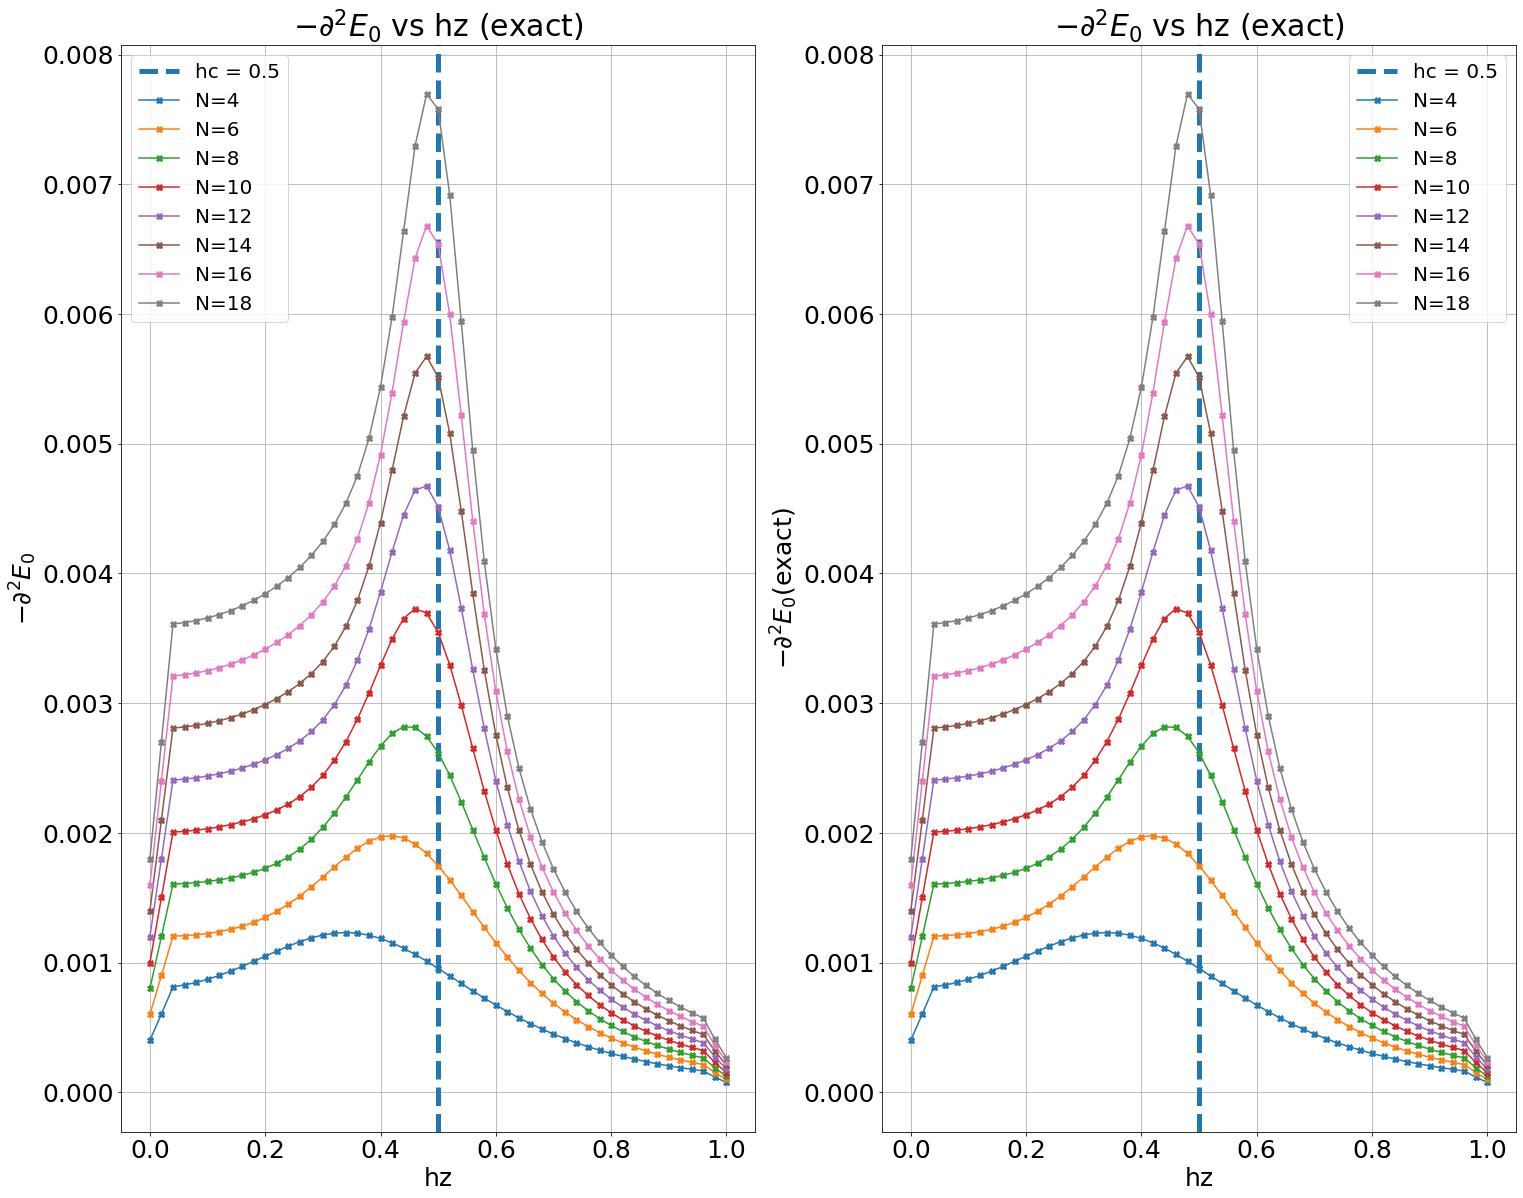

In [12]:
fig, ax = plt.subplots(1,2,figsize=(25,20))
for l in range(len(Llist)):
    L = Llist[l]
    if(l==0):
        ax[0].axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[0].plot(hz[:],-np.gradient(np.gradient(E0[l,:])), "-X", label = "N=%d" %L)
    ax[0].set_title("$-\partial^{2}{E_0}}/\partial{h^{2}_{z}}$ vs hz (exact)", fontsize = 30)
    ax[0].set_ylabel("$-\partial^{2}{E_0}}/\partial{h^{2}_{z}}$", fontsize = 25)
    ax[0].set_xlabel("hz", fontsize = 25)
    ax[0].tick_params(axis='x', labelsize=25)
    ax[0].tick_params(axis='y', labelsize=25)
    ax[0].legend(loc = "upper left", fontsize=20)
    ax[0].grid("True")

    if(l==0):
        ax[1].axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[1].plot(hz[:],-np.gradient(np.gradient((E0_exact[l,:]))), "-X", label = "N=%d" %L)
    ax[1].set_title("$-\partial^{2}{E_0}}/\partial{h^{2}_{z}}$ vs hz (exact)", fontsize = 30)
    ax[1].set_ylabel("$-\partial^{2}{E_0}}/\partial{h^{2}_{z}}$(exact)", fontsize = 25)
    ax[1].set_xlabel("hz", fontsize = 25)
    ax[1].tick_params(axis='x', labelsize=25)
    ax[1].tick_params(axis='y', labelsize=25)
    ax[1].legend(loc = "best", fontsize=20)
    ax[1].grid("True")

* <font size=6 face="黑體"> Since the ground state symmetry is spontaneous broken below $h_c$ = 0.5, $<S_{x}>_{H_{0}+0.01*S_{x}}$ must be finite below critical point $h_c$ = 0.5

* <font size=5 face="黑體"> $<S_{x}>_{H=H_{0}+0.01*S_{x}}$

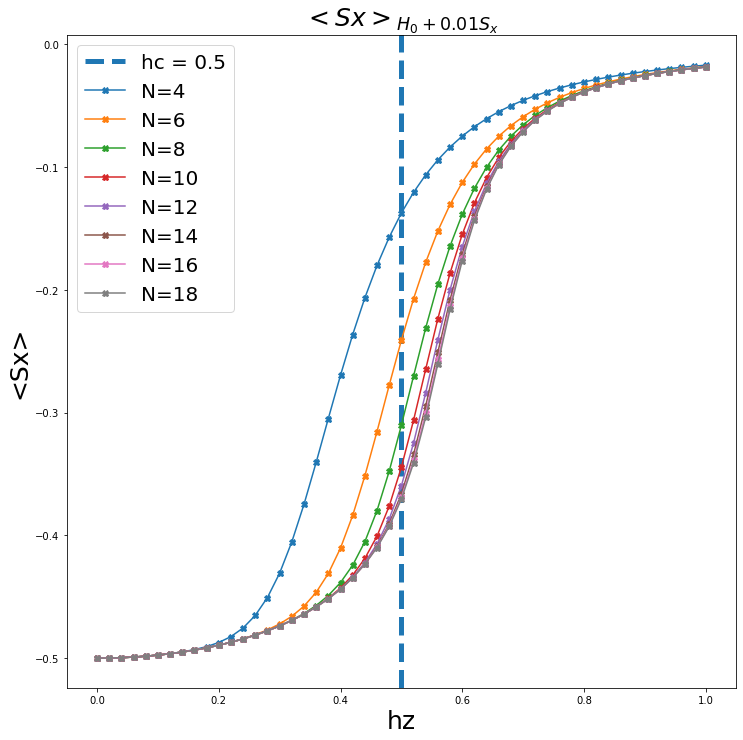

In [13]:
fig = plt.figure(figsize=(12,12))
for l in range(len(Llist)):
    L = Llist[l]
    if(l==0):
        plt.axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    plt.plot(hz[:], SxE[l,:], "-X", label = "N=%d" %L)
    plt.title("$<Sx>_{H_{0}+0.01S_{x}}$", fontsize = 25)
    plt.ylabel("<Sx>", fontsize = 25)
    plt.xlabel("hz", fontsize = 25)
    plt.legend(loc = "upper left", fontsize=20)

* <font size=5 face="黑體"> $|<S_{x}>|_{H=H_{0}+0.01*S_{x}}$

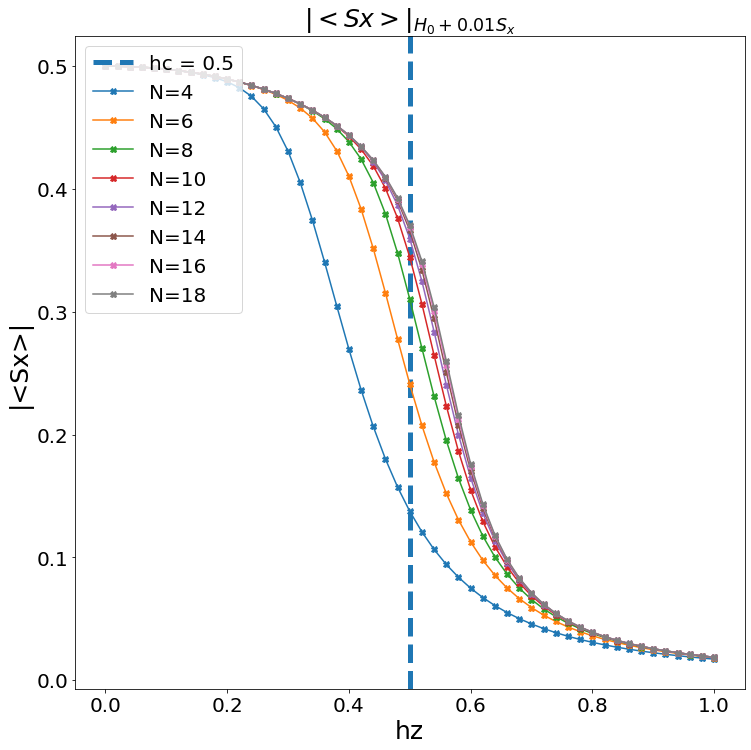

In [14]:
fig = plt.figure(figsize=(12,12))
for l in range(len(Llist)):
    L = Llist[l]
    if(l==0):
        plt.axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    plt.plot(hz[:], np.abs(SxE[l,:]), "-X", label = "N=%d" %L)
    plt.title("$|<Sx>|_{H_{0}+0.01S_{x}}$", fontsize = 25)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.ylabel("|<Sx>|", fontsize = 25)
    plt.xlabel("hz", fontsize = 25)
    plt.legend(loc = "upper left", fontsize=20)

* <font size=5 face="黑體"> $<S_{z}>$

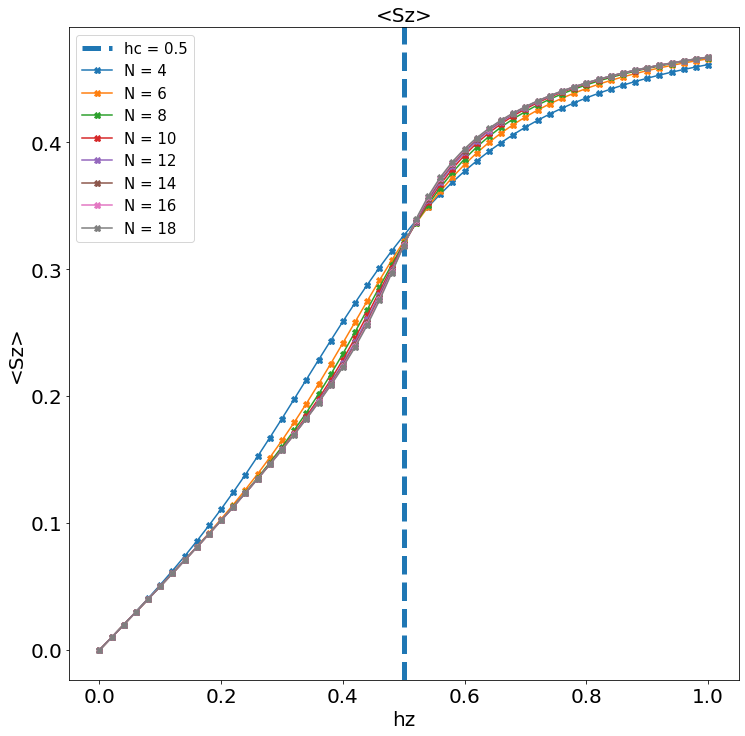

In [15]:
fig = plt.figure(figsize=(12,12))
for l in range(len(Llist)):
    L = Llist[l]
    if(l==0):
        plt.axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    plt.plot(hz[:], SzE[l,:], "-X", label = "N = %d" %L)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.title("<Sz>", fontsize = 20)
    plt.ylabel("<Sz>", fontsize = 20)
    plt.xlabel("hz", fontsize = 20)
    plt.legend(loc = "upper left", fontsize=15)

* <font size=6 face="黑體"> Compare Bipartite Entropy Growth near vritical point $h_{z}$ = 0.5

* <font size=5 face="黑體"> $S_{A/B}$ vs $ln(N)$

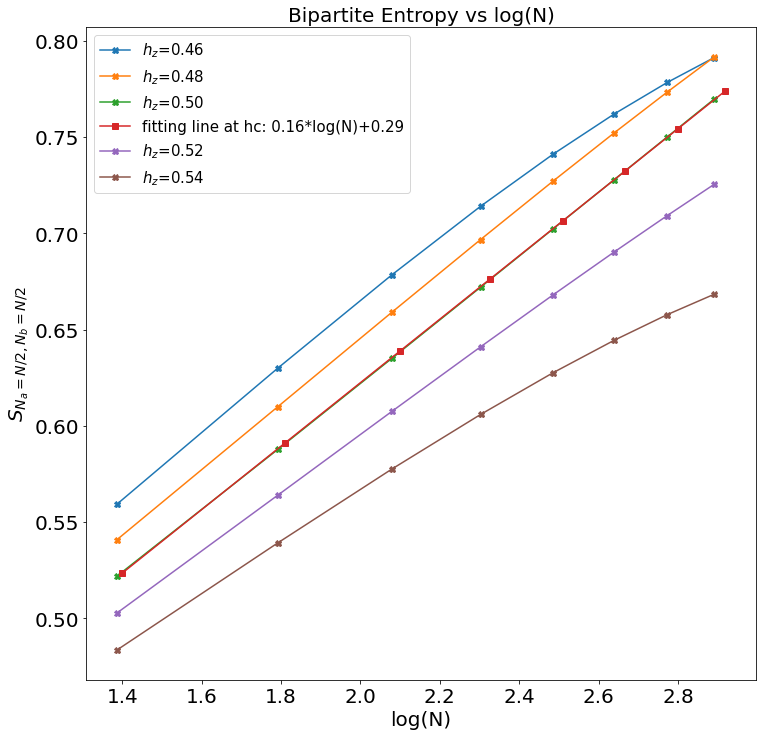

In [16]:
fig = plt.figure(figsize=(12,12))
entropyForAsize = np.zeros((len(Llist),len(hz)))

for l in range(len(Llist)):
    L = Llist[l]
    for h in range(len(hz)):
        entropyForAsize[l,h] = entropy[l][Llist[l]//2,h]
        
for hz_i in range(len(hz[0:(len(hz)+1)//2 + 2])):
    if(hz_i >= (len(hz)-1)//2 - 2):
        plt.plot(np.log(Llist),entropyForAsize[:,hz_i], "-X", label = "$h_{z}$=%.2f" %(hz[hz_i]))
        plt.ylabel("$S_{N_{a}=N/2,N_{b}=N/2}}$", fontsize = 20)
        plt.tick_params(axis='x', labelsize=20)
        plt.tick_params(axis='y', labelsize=20)
        plt.xlabel("log(N)", fontsize = 20)
        plt.title("Bipartite Entropy vs log(N)", fontsize = 20)
        plt.legend(loc = "upper left", fontsize=15)
        if(hz_i==25):
            x = 1.01*np.log(Llist)
            poly = np.polyfit(np.log(Llist),entropyForAsize[:,hz_i],1)
            y = poly[0]*x + poly[1]
            plt.plot(x,y,"-s", label = "fitting line at hc: %.2f*log(N)+%.2f" %(poly[0],poly[1]))


* <font size=5 face="黑體"> $S_{A}$ vs $N_{A}$ ( Entropy of Subsystem $N_{A} = 1,2,3...N_{A}$ )


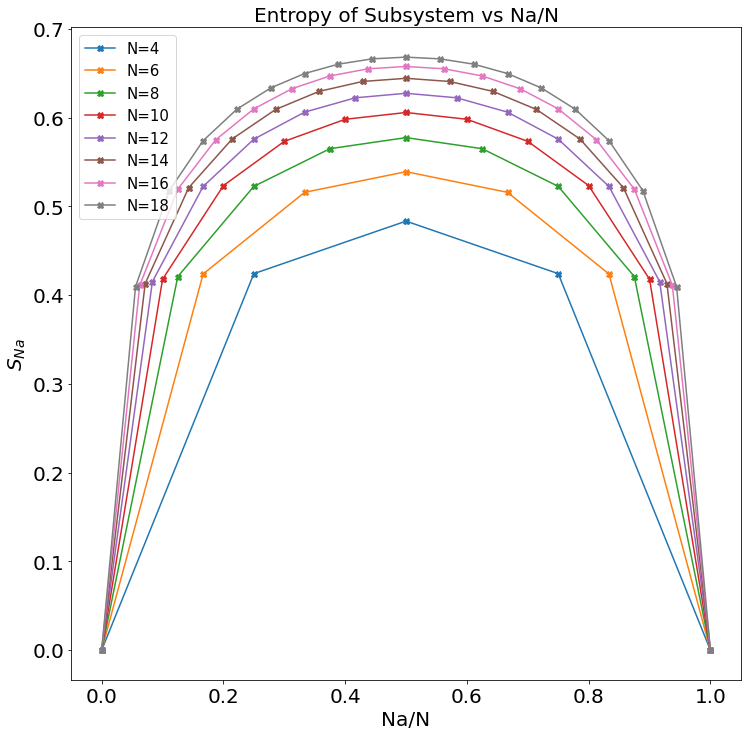

In [17]:
fig = plt.figure(figsize=(12,12))
entropyForAsize = np.zeros((len(Llist),len(hz)))

for l in range(len(Llist)):
    L = Llist[l]
    for h in range(len(hz)):
        entropyForAsize[l,h] = entropy[l][Llist[l]//2,h]
        
for l in range(len(Llist)):
    Na = np.linspace(max(Llist)//2 - Llist[l]//2,max(Llist)//2 + Llist[l]//2,Llist[l]+1)
    SNa = []
    for i in range(len(Na)):
        SNa.append((Na[i]-Na[0])/(Na[-1]-Na[0]))
    plt.plot(SNa[:],entropy[l][:,hz_i], "-X", label = "N=%d" %(Llist[l]))
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.ylabel("$S_{Na}$", fontsize = 20)
    plt.xlabel("Na/N", fontsize = 20)
    plt.title("Entropy of Subsystem vs Na/N", fontsize = 20)
    plt.legend(loc = "upper left", fontsize=15)

### Overview

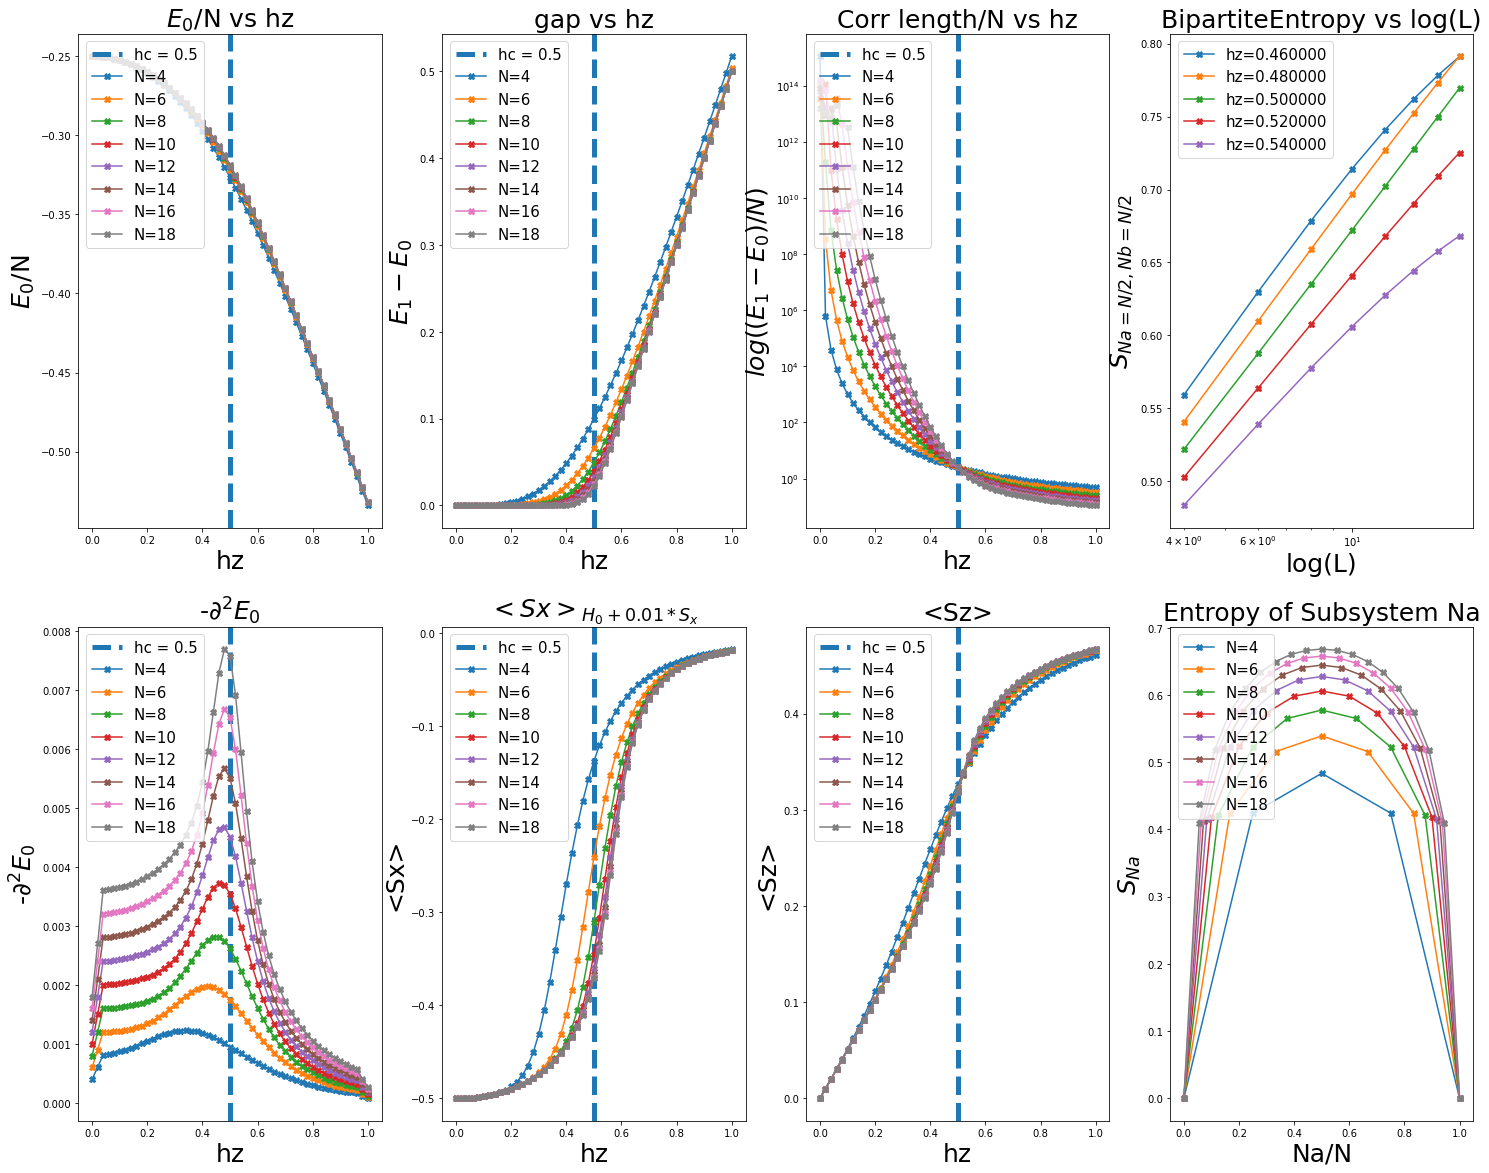

In [18]:
fig, ax = plt.subplots(2,4,figsize=(25,20))
entropyForAsize = np.zeros((len(Llist),len(hz)))
for l in range(len(Llist)):
    L = Llist[l]
    if(l==0):
        ax[0][0].axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[0][0].plot(hz[:],E0[l,:]/L, "-X", label = "N=%d" %L)
    ax[0][0].set_title("$E_0$/N vs hz", fontsize = 25)
    ax[0][0].set_ylabel("$E_0$/N", fontsize = 25)
    ax[0][0].set_xlabel("hz", fontsize = 25)
    ax[0][0].legend(loc = "upper left", fontsize=15)

    if(l==0):
        ax[0][1].axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[0][1].plot(hz[:],gap[l,:], "-X", label = "N=%d" %L)
    ax[0][1].set_title("gap vs hz", fontsize = 25)
    ax[0][1].set_ylabel("$E_{1}-E_{0}$", fontsize = 25)
    ax[0][1].set_xlabel("hz", fontsize = 25)
    ax[0][1].legend(loc = "upper left", fontsize=15)

    if(l==0):
        ax[0][2].axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[0][2].plot(hz[:],lamda[l,:], "-X", label = "N=%d" %L)
    ax[0][2].set_title("Corr length/N vs hz", fontsize = 25)
    ax[0][2].legend(loc = "upper left", fontsize=15)
    ax[0][2].set_ylabel("$log((E_1-E_0)/N)$", fontsize = 25)
    ax[0][2].set_xlabel("hz", fontsize = 25)
    ax[0][2].set_yscale('log')

    if(l==0):
        ax[1][0].axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[1][0].plot(hz[:], -np.gradient(np.gradient(E0[l,:])), "-X", label = "N=%d" %L)
    ax[1][0].set_title("-$\partial^{2}E_0$", fontsize = 25)
    ax[1][0].set_ylabel("-$\partial^{2}E_0$", fontsize = 25)
    ax[1][0].set_xlabel("hz", fontsize = 25)
    ax[1][0].legend(loc = "upper left", fontsize=15)

    if(l==0):
        ax[1][1].axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[1][1].plot(hz[:], SxE[l,:], "-X", label = "N=%d" %L)
    ax[1][1].set_title("$<Sx>_{H_{0}+0.01*S_{x}}$", fontsize = 25)
    ax[1][1].set_ylabel("<Sx>", fontsize = 25)
    ax[1][1].set_xlabel("hz", fontsize = 25)
    ax[1][1].legend(loc = "upper left", fontsize=15)

    if(l==0):
        ax[1][2].axvline(x=.5, ymin=0, ymax=10, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[1][2].plot(hz[:], SzE[l,:], "-X", label = "N=%d" %L)
    ax[1][2].set_title("<Sz>", fontsize = 25)
    ax[1][2].set_ylabel("<Sz>", fontsize = 25)
    ax[1][2].set_xlabel("hz", fontsize = 25)
    ax[1][2].legend(loc = "upper left", fontsize=15)

    for h in range(len(hz)):
        entropyForAsize[l,h] = entropy[l][Llist[l]//2,h]


for hz_i in range(len(hz[0:(len(hz)+1)//2+2])):
    if(hz_i >= (len(hz)-1)//2 - 2):
        ax[0][3].plot(Llist[:],entropyForAsize[:,hz_i], "-X", label = "hz=%f" %(hz[hz_i]))
        ax[0][3].set_ylabel("$S_{Na=N/2,Nb=N/2}$", fontsize = 25)
        ax[0][3].set_xlabel("log(L)", fontsize = 25)
        ax[0][3].set_title("BipartiteEntropy vs log(L)", fontsize = 25)
        ax[0][3].legend(loc = "upper left", fontsize=15)
        ax[0][3].set_xscale('log')
    
for l in range(len(Llist)):
    Na = np.linspace(max(Llist)//2 - Llist[l]//2,max(Llist)//2 + Llist[l]//2,Llist[l]+1)
    SNa = []
    for i in range(len(Na)):
        SNa.append((Na[i]-Na[0])/(Na[-1]-Na[0]))
    ax[1][3].plot(SNa[:],entropy[l][:,hz_i], "-X", label = "N=%d" %(Llist[l]))
    ax[1][3].set_ylabel("$S_{Na}$", fontsize = 25)
    ax[1][3].set_xlabel("Na/N", fontsize = 25)
    ax[1][3].set_title("Entropy of Subsystem Na", fontsize = 25)
    ax[1][3].legend(loc = "upper left", fontsize=15)
    
plt.show()

### Gap 在 hc 時會變得非常 sharp, scaling like $\Delta_{c}=\Delta_{0}*L^{-v}$

* check 在 h = hc 時 Gap 外推會剛好在 0

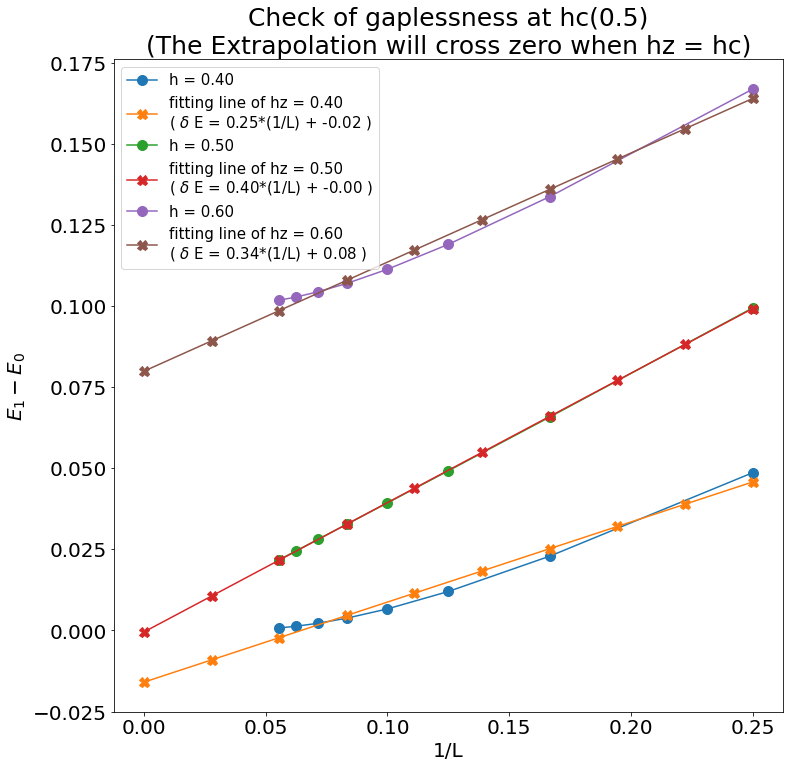

In [19]:
fig = plt.figure(figsize=(12,12))
Linverse = []
for i in range(len(Llist)):
    Linverse.append(1/Llist[i])
hz_list = [20,25,30]

for hz_i in hz_list:
    poly = np.polyfit(Linverse,gap[:,hz_i],1)
    x = np.linspace(0,0.25,10)
    y = poly[0]*x + poly[1]
    plt.title("Check of gaplessness at hc(0.5)\n(The Extrapolation will cross zero when hz = hc)", fontsize = 25)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.plot(Linverse,gap[:,hz_i],marr[0],markersize = 10 ,label = "h = %.2f" %(hz[hz_i]) )
    plt.plot(x,y,"-X",label = "fitting line of hz = %.2f\n( $\delta$ E = %.2f*(1/L) + %.2f )" %(hz[hz_i],poly[0],poly[1]), markersize = 10)
    plt.xlabel("1/L",fontsize = 20)
    plt.ylabel("$E_{1}-E_{0}$",fontsize = 20)
    plt.legend(loc = "best", fontsize = 15)

* fitting to find the scaling constant

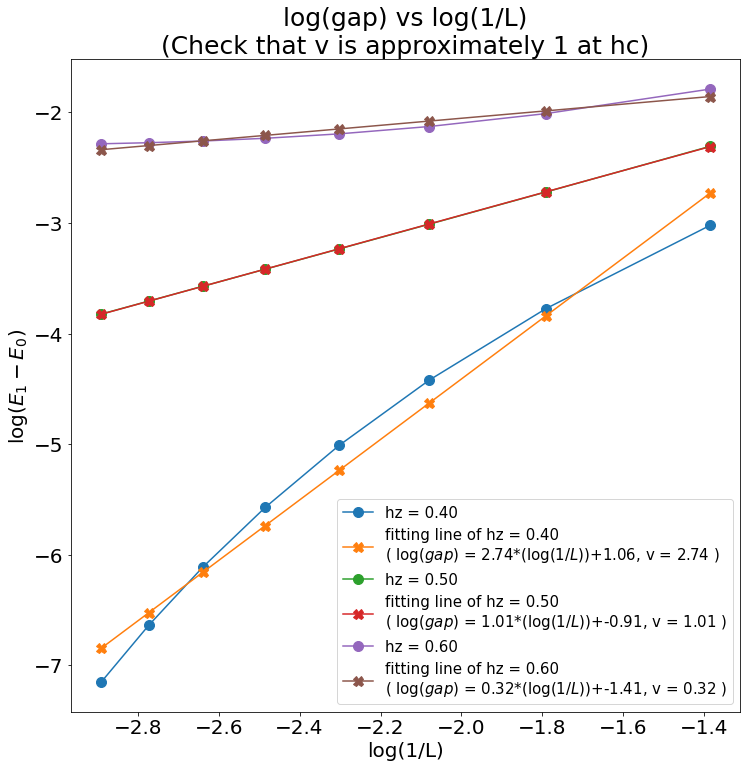

In [20]:
Linverse = []
for i in range(len(Llist)):
    Linverse.append(1/Llist[i])

hz_list = [20,25,30]

def func(x, a, b, c):
    return a*x**b + c

fig = plt.figure(figsize=(12,12))

for hz_i in range(len(hz_list)):
    poly = np.polyfit(np.log(Linverse), np.log(gap[:,hz_list[hz_i]]),1)
    x = np.log(Linverse)
    y = poly[0]*x + poly[1]

    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.title("log(gap) vs log(1/L)\n(Check that v is approximately 1 at hc)", fontsize = 25)
    plt.plot(np.log(Linverse),np.log(gap[:,hz_list[hz_i]]),marr[0],markersize = 10 ,label = "hz = %.2f" %(hz[hz_list[hz_i]]) )
    plt.plot(x,y,"-X",label = "fitting line of hz = %.2f\n( $\log(gap)$ = %.2f*($\log(1/L)$)+%.2f, v = %.2f )" %(hz[hz_list[hz_i]],poly[0],poly[1],poly[0]), markersize = 10)
    plt.xlabel("log(1/L)",fontsize = 20)
    plt.ylabel("$\log(E_{1}-E_{0})$",fontsize = 20)
    plt.legend(loc = "best", fontsize = 15)

### 交點外推求 Tc

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


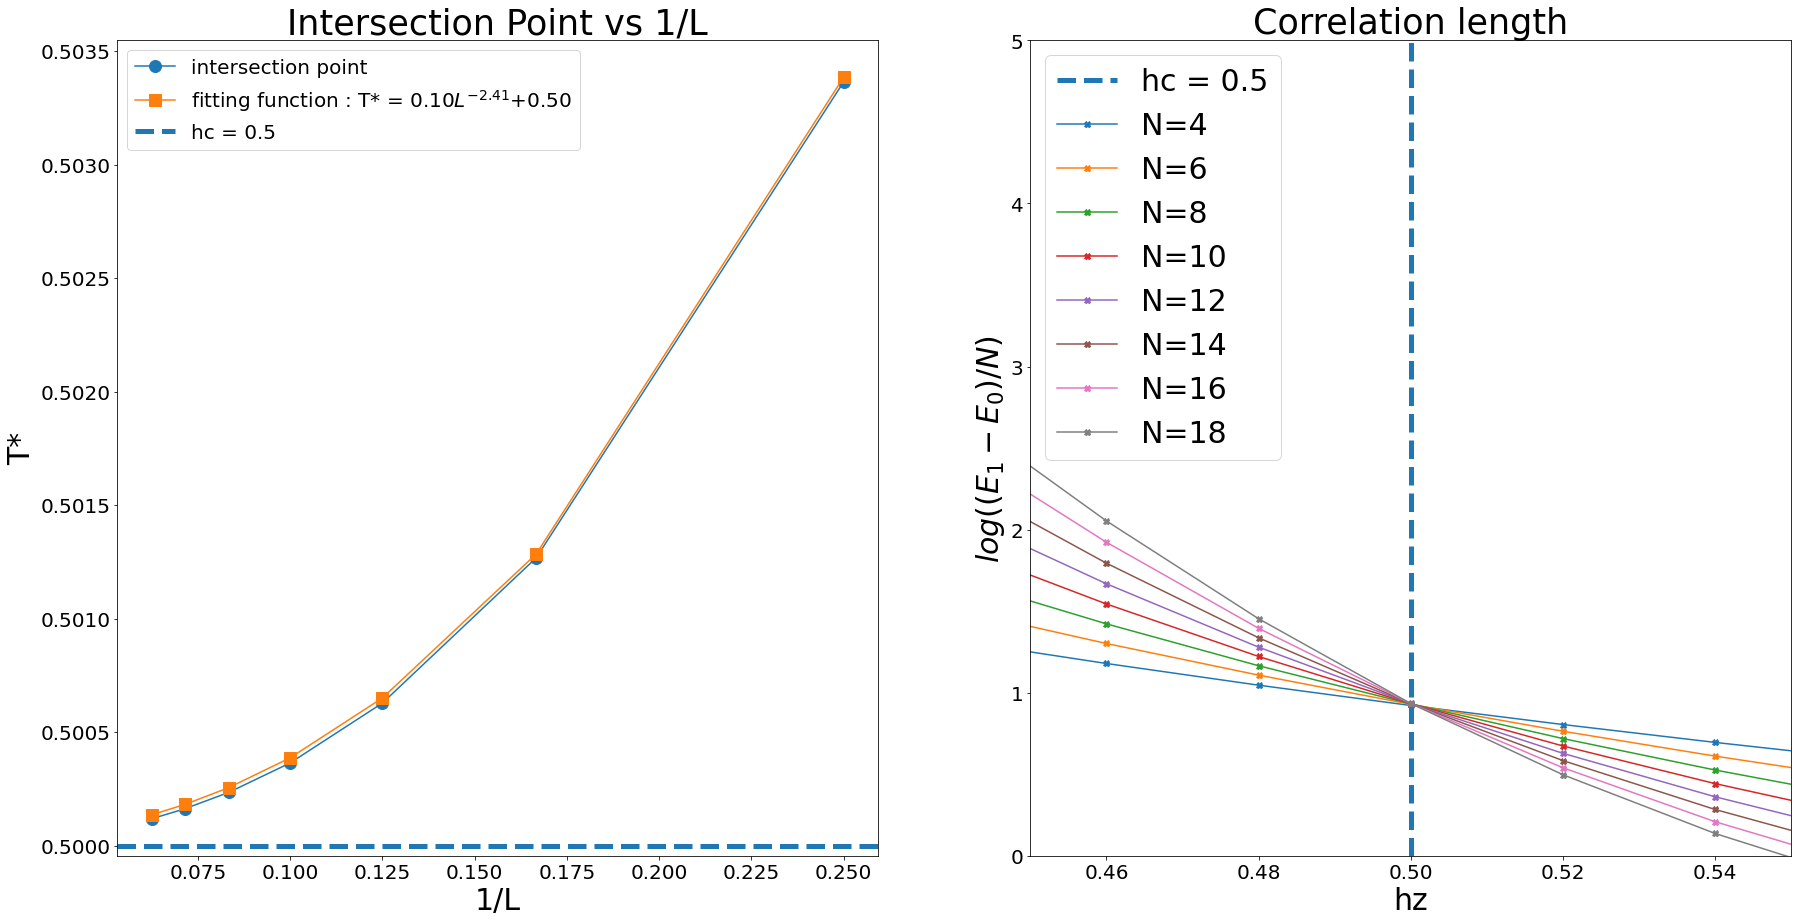

<Figure size 864x864 with 0 Axes>

In [27]:
Linverse = [(1/i) for i in range (4,18,2)]
hzlist = [i for i in range (20,30)]

hc = np.zeros(len(Llist)-1)
print(hzlist)

fig, ax = plt.subplots(1,2,figsize=(30,15))


plt.figure(figsize=(12,12))
for i in range(len(Llist)-1):
    for hz_i in hzlist:
        if((lamda[i+1,hz_i] - lamda[i,hz_i])*(lamda[i+1,hz_i+1] - lamda[i,hz_i+1]) < 0):
            p1 = np.polyfit([hz[hz_i],hz[hz_i+1]],[lamda[i,hz_i],lamda[i,hz_i+1]],1)
            p2 = np.polyfit([hz[hz_i],hz[hz_i+1]],[lamda[i+1,hz_i],lamda[i+1,hz_i+1]],1)
            hc[i] = np.roots(p1 -p2)

def func(x, a, b, c):
    return a * x ** b + c

popt, pcov = curve_fit(func, Linverse, hc, maxfev=40000)
y = func(Linverse,*popt) +0.00002


ax[0].plot(Linverse[:],hc[:],"-o", markersize = 12, label = "intersection point")
ax[0].plot(Linverse[:],y[:],"-s", markersize = 12, label = "fitting function : T* = %.2f$L^{-%.2f}$+%.2f" %(popt[0],popt[1],popt[2]))
ax[0].tick_params(axis='x', labelsize=20)
ax[0].tick_params(axis='y', labelsize=20)
ax[0].set_title("Intersection Point vs 1/L",fontsize = 35)
ax[0].axhline(y=0.5, ls = "--", linewidth = 5 ,label = "hc = 0.5")
ax[0].set_xlabel("1/L",fontsize = 30)
ax[0].set_ylabel("T*",fontsize = 30)
ax[0].legend(loc = "best", fontsize = 20)

for l in range(len(Llist)):
    L = Llist[l]
    if(l==0):
        ax[1].axvline(x=.5, ymin=0, ymax=1, ls = "--", linewidth = 5 ,label = "hc = 0.5")
    ax[1].plot(hz[:],np.log(lamda[l,:]), "-X", label = "N=%d" %L)
    ax[1].tick_params(axis='x', labelsize=20)
    ax[1].tick_params(axis='y', labelsize=20)
    ax[1].set_title("Correlation length", fontsize = 35)
    ax[1].legend(loc = "upper left", fontsize=30)
    ax[1].set_ylabel("$log((E_1-E_0)/N)$", fontsize = 30)
    ax[1].set_xlabel("hz", fontsize = 30)
    ax[1].set_ylim(0,5)
    ax[1].set_xlim(0.45,0.55)
